In [6]:
import os
import numpy as np
import cv2
import torch
import torch.optim as optim

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.datasets import MultiTemporalCropClassification
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger

## MultiTemporalCrop Example

In [7]:
# path to access the dataset
DATASET_PATH = os.path.join('root_dir', 'hls_cdl_reclassed')

In [8]:
# those are the recommended transforms for this task
transforms = [
    terratorch.datasets.transforms.FlattenTemporalIntoChannels(),
    albumentations.HorizontalFlip(),
    albumentations.pytorch.transforms.ToTensorV2(),
    terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
]

In [9]:
# this datamodule allows access to the dataset in its various splits.
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
)

In [10]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [11]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

3083

In [12]:
# checking datasets available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [13]:
# checking datasets classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

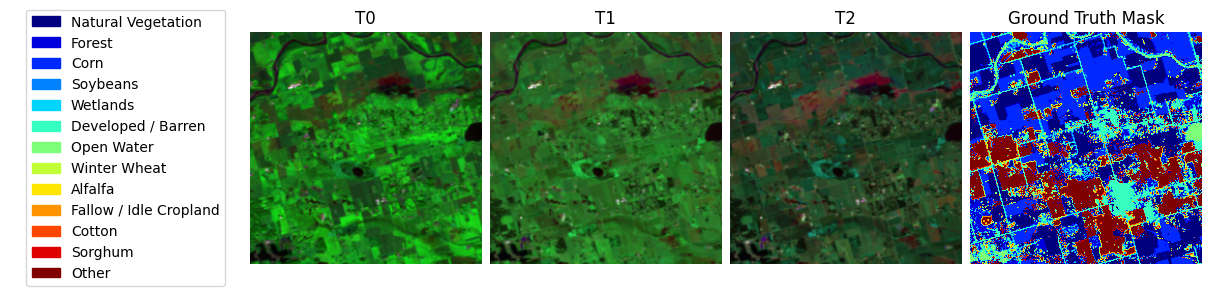

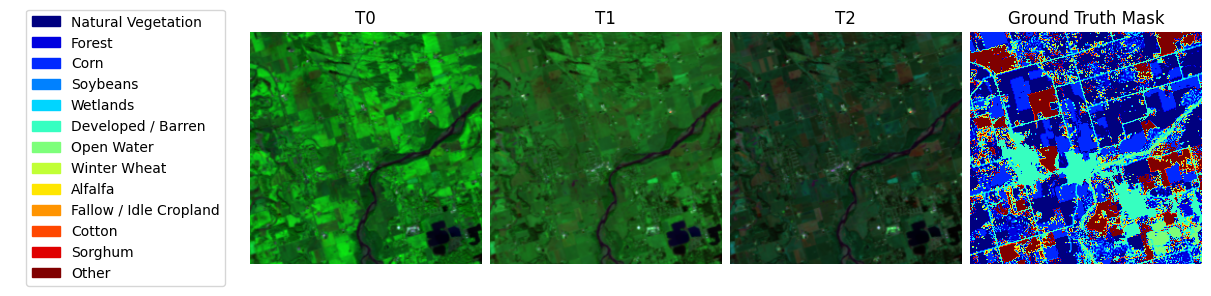

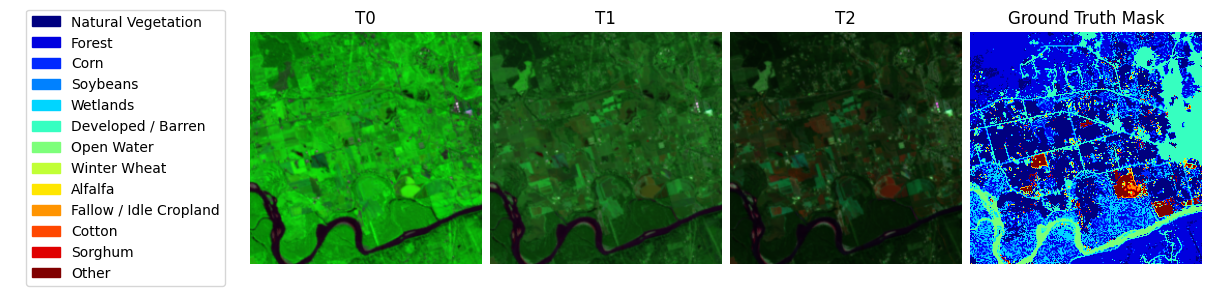

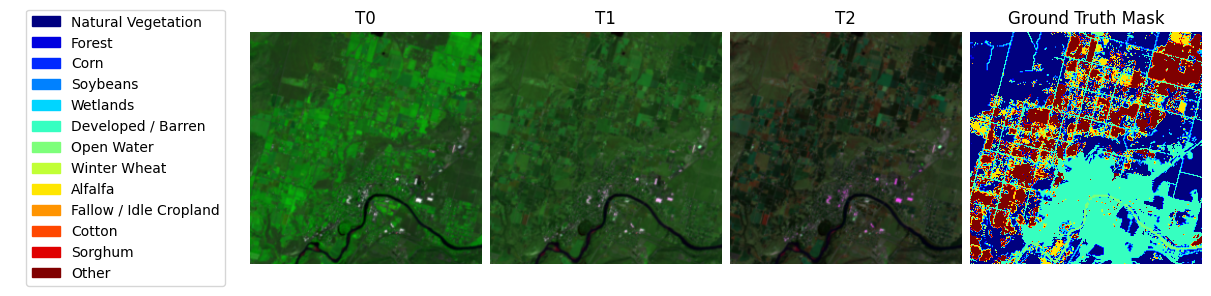

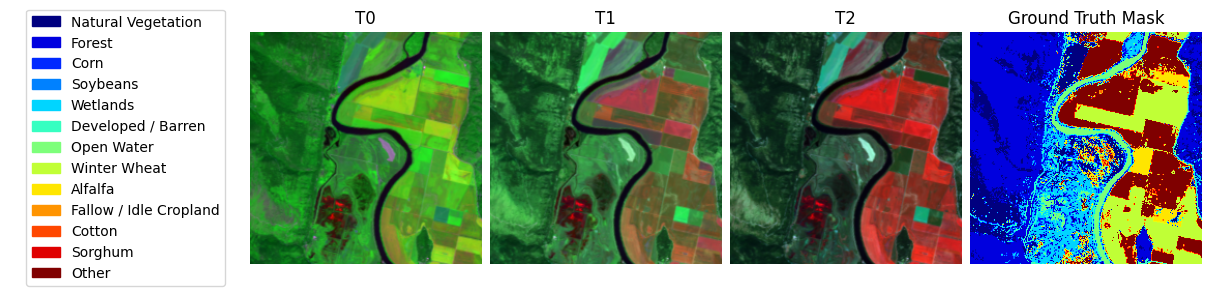

In [14]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [15]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

771

In [16]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

771

In [18]:
# Logger
logger = TensorBoardLogger(
    save_dir="output",
    name="tutorial"
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    num_nodes=1,
    logger = logger,
    precision="16-mixed",
    max_epochs=1,
    check_val_every_n_epoch=1,
    log_every_n_steps=1,
    enable_checkpointing=False,
    default_root_dir="root_dir",
)

# DataModule
data_module = MultiTemporalCropClassificationDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    reduce_zero_label=True,
    expand_temporal_dimension=True,
    use_metadata=True, # Multicropclassification dataset has metadata for location and time
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": False,
        "backbone": "prithvi_vit_300", # Model can be either prithvi_vit_100, prithvi_vit_300 or prithvi_vit_600
        "backbone_in_channels": 6,
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 3,
        "num_classes": 13,
        "head_dropout": 0.1,
        "decoder_channels": 512,
        "decoder_scale_modules": True,
        "head_channel_list": [128, 64]
    },
    plot_on_val=False,
    loss="ce",
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1.5e-5,
    weight_decay=0.05
)


# Training
trainer.fit(model, datamodule=data_module)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/dccstor/geofm-finetuning/pedrohc/miniforge3/envs/benchmark/lib/python3.10/site-packages/lightning/pytorch/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [19]:
# after training, check the result metrics on test split
trainer.test(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.26032185554504395         │
│      test/Multiclass_F1_Score       │         0.26032185554504395         │
│    test/Multiclass_Jaccard_Index    │         0.13444916903972626         │
│ test/Multiclass_Jaccard_Index_Micro │         0.14963795244693756         │
│              test/loss              │          2.049137592315674          │
│      test/multiclassaccuracy_0      │         0.11142702400684357         │
│      test/multiclassaccuracy_1      │         0.3820958733558655          │
│     test/multiclassaccuracy_10      │         0.13319694995880127         │
│     test/multiclassaccuracy_11      │         0.28589320182800293         │
│     test/multiclassaccuracy_12      │         0.03388471528887749         │
│      test/multiclassaccuracy_2      │         0.09424404054880142         │
│      test/multiclassaccuracy_3      │         0.8222865462303162          │
│      test/multiclassaccuracy_4      │         0.40726903080940247         │
│      test/multiclassaccuracy_5      │       0.00034516415325924754        │
│      test/multiclassaccuracy_6      │         0.5357452034950256          │
│      test/multiclassaccuracy_7      │         0.1264924705028534          │
│      test/multiclassaccuracy_8      │                 0.0                 │
│      test/multiclassaccuracy_9      │         0.2977605164051056          │
│    test/multiclassjaccardindex_0    │         0.0939343124628067          │
│    test/multiclassjaccardindex_1    │         0.21685072779655457         │
│   test/multiclassjaccardindex_10    │         0.0812481939792633          │
│   test/multiclassjaccardindex_11    │         0.11667203903198242         │
│   test/multiclassjaccardindex_12    │        0.029797520488500595         │
│    test/multiclassjaccardindex_2    │         0.05908241868019104         │
│    test/multiclassjaccardindex_3    │         0.21286515891551971         │
│    test/multiclassjaccardindex_4    │         0.2553982138633728          │
│    test/multiclassjaccardindex_5    │       0.00034448577207513154        │
│    test/multiclassjaccardindex_6    │         0.45629534125328064         │
│    test/multiclassjaccardindex_7    │         0.09452731907367706         │
│    test/multiclassjaccardindex_8    │                 0.0                 │
│    test/multiclassjaccardindex_9    │         0.13082362711429596         │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 2.049137592315674,
  'test/Multiclass_Accuracy': 0.26032185554504395,
  'test/multiclassaccuracy_0': 0.11142702400684357,
  'test/multiclassaccuracy_1': 0.3820958733558655,
  'test/multiclassaccuracy_2': 0.09424404054880142,
  'test/multiclassaccuracy_3': 0.8222865462303162,
  'test/multiclassaccuracy_4': 0.40726903080940247,
  'test/multiclassaccuracy_5': 0.00034516415325924754,
  'test/multiclassaccuracy_6': 0.5357452034950256,
  'test/multiclassaccuracy_7': 0.1264924705028534,
  'test/multiclassaccuracy_8': 0.0,
  'test/multiclassaccuracy_9': 0.2977605164051056,
  'test/multiclassaccuracy_10': 0.13319694995880127,
  'test/multiclassaccuracy_11': 0.28589320182800293,
  'test/multiclassaccuracy_12': 0.03388471528887749,
  'test/Multiclass_F1_Score': 0.26032185554504395,
  'test/Multiclass_Jaccard_Index': 0.13444916903972626,
  'test/multiclassjaccardindex_0': 0.0939343124628067,
  'test/multiclassjaccardindex_1': 0.21685072779655457,
  'test/multiclassjaccardindex_2': 0